# Noise Filtering and Volume Computation in LiDAR Scanning

In this notebook, we'll be processing LiDAR scans using Open3D. The objective is to efficiently remove noise from the target object and proceed to compute its volume.

In [17]:
import alphashape
import open3d as o3d
from vedo import *
import pyvista as pv

import numpy as np
import matplotlib.pyplot as plt

settings.default_backend = 'ipyvtk' 
pv.set_jupyter_backend('trame')

## Step 1: Load the Point Cloud

Load the point cloud from a given path. Ensure that the file exists before attempting to read.


In [18]:
file_path = ''
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

pcl = o3d.io.read_point_cloud(file_path)
o3d.visualization.draw_geometries([pcl])
print(np.asarray(np.size(pcl.points)))

6097380


## Step 2: Voxel Downsampling and Visualize the Axis-Aligned Bounding Box

Downsample the point cloud to reduce the number of points and make further processing faster. Choose the voxel size carefully to retain important details. Compute and visualize the bounding box of the point cloud.


In [19]:
pcl = pcl.voxel_down_sample(voxel_size=0.04)

axis_aligned_bbox = pcl.get_axis_aligned_bounding_box() 
axis_aligned_bbox.color = (1, 0, 0)

o3d.visualization.draw_geometries([pcl, axis_aligned_bbox])
print(np.asarray(np.size(pcl.points)))

20931


## Step 3: Point Cloud Flipping & Combination

Create a mirrored version of the point cloud and combine it with the original.


In [20]:
flipped_pcl = o3d.geometry.PointCloud()
flipped_pcl.points = o3d.utility.Vector3dVector(np.asarray(pcl.points) * [-1,-1, -1])
combined_points = np.vstack((np.asarray(pcl.points), np.asarray(flipped_pcl.points)))
combined_pcl = o3d.geometry.PointCloud()
combined_pcl.points = o3d.utility.Vector3dVector(combined_points)

In [21]:
o3d.visualization.draw_geometries([combined_pcl])

## Step 4: Alpha Shape Generation

Using the combined point cloud, generate an alpha shape.


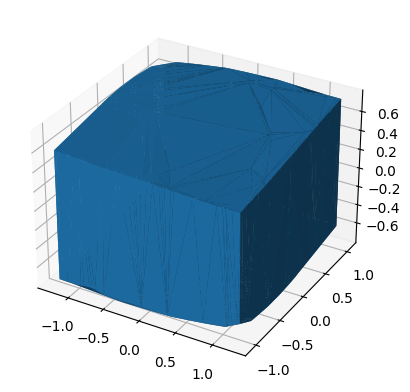

In [22]:
alpha_shape = alphashape.alphashape(combined_points, 0.1)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(*zip(*alpha_shape.vertices), triangles=alpha_shape.faces)
plt.show()

## Step 5: Generate Random Barycentric Coordinates

For visualization and further processing, generate random barycentric coordinates on the alpha shape.

we are working with a triangular mesh (a collection of triangles) represented by its vertices and face indices. We aim to generate a list of points, `pcl_points`, that contains the vertices of this mesh and additional points that are randomly sampled within each triangle of the mesh.


In [23]:
pcl_points = [vertex for vertex in alpha_shape.vertices]

for face in alpha_shape.faces:
    v1, v2, v3 = alpha_shape.vertices[face]
    for _ in range(20):
        r1, r2 = np.random.random(), np.random.random()
        if r1 + r2 > 1:
            r1, r2 = 1 - r1, 1 - r2
        point = (1 - r1 - r2) * v1 + r1 * v2 + r2 * v3
        pcl_points.append(point)

outer_pcl = o3d.geometry.PointCloud()
outer_pcl.points = o3d.utility.Vector3dVector(np.array(pcl_points))
o3d.visualization.draw_geometries([outer_pcl, axis_aligned_bbox])


## Step 6: Point Cloud Distance Computation

Compute distances between points in the original point cloud and the outer "filter" point cloud.


In [25]:
distances = pcl.compute_point_cloud_distance(outer_pcl)

# Set the threshold for masking based on point cloud size
threshold = 0.4 if np.asarray(np.size(pcl.points)) >= 100000 else 0.1

mask = np.asarray(distances) < threshold

pcl_masked = pcl.select_by_index(np.where(mask)[0], invert=True)

## Step 7: Outlier Removal

Remove statistical outliers from the point cloud for a cleaner result.


In [26]:
cl, ind = pcl_masked.remove_statistical_outlier(nb_neighbors=350, std_ratio=0.6)
o3d.visualization.draw_geometries([cl])


## Step 8: Convex Hull Calculation

Calculate the convex hull of the cleaned point cloud. We will use this for volume and area calculations.


In [27]:
hull, _ = cl.compute_convex_hull()
hull = hull.simplify_quadric_decimation(target_number_of_triangles=100)
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([cl, hull_ls])

volume_m3 = hull.get_volume() 
print("Volume of the convex hull:", volume_m3) 

Volume of the convex hull: 1.212981896071924


### Volume Conversion: Cubic Meters to Cubic Feet


$$V_{\text{ft}^3} = 35.3147 \times V_{\text{m}^3}$$

By using this equation, you can convert any volume value from cubic meters to its equivalent in cubic feet.

In [28]:
conversion_factor = 35.3147
volume_ft3 = volume_m3 * conversion_factor

print("Volume in cubic feet:", volume_ft3) 

Volume in cubic feet: 42.83609176521118


To visualize within the nootbook will need to use pyvista

In [29]:
pv_cloud = pv.PolyData(np.asarray(cl.points))
pv_cloud['point_color'] = np.asarray(cl.colors) 

#pv.plot(pv_cloud, scalars='point_color')

Turinig an .obj into .ply

In [32]:
def mesh_to_point_cloud(filepath, number_of_points=2000):
    
    mesh = o3d.io.read_triangle_mesh(filepath)
    mesh.compute_vertex_normals()
    
    pcl = mesh.sample_points_poisson_disk(number_of_points)
    
    return pcl


Plane detection in a point cloud

In [31]:
plane_model, inliers = pcl.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcl.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcl.select_by_index(inliers, invert=True)

o3d.visualization.draw_geometries([outlier_cloud])


Plane equation: -0.58x + 0.71y + 0.39z + -0.43 = 0
